# Natural Language processing (NLP)

Political Bias Detection with our dataset defined with Rationnal wiki and Conservpedia

"Biased left" = 0, "Neutral" = 1, "Biased right" = 2

The training set only contain left and right biased text, a threshold will be applied on the test set to define Neutral text

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

#NLP libraries
import nltk
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument
import urllib

#Machine learning libraries
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#Helper libraries
import multiprocessing
import numpy as np
import pandas as pd
import math
from bs4 import BeautifulSoup
import re
import os


nltk.download('punkt', download_dir="./data_model/")
nltk.download("stopwords", download_dir="./data_model/")
nltk.data.path.append(os.path.abspath("./data_model/"))

[nltk_data] Downloading package punkt to ./data_model/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ./data_model/...
[nltk_data]   Package stopwords is already up-to-date!


## Importing All the data : 
- Training data : Rationnal wiki (biased left) and Conservpedia (biased right)
- Test data : Wikispeedia pages that we want to predict the bias
- Verification data : Dataset of university of Zurich that treat bias with text

In [21]:
#Training data
train_data=pd.read_csv("./data_model/labeled_dataset_english.csv", header=0, usecols=["article", "type"], dtype=str)

train_data["type"]=train_data["type"].replace(['left','center','right'],[0,1,2])

train_data=train_data.rename(columns={"type": "bias", "article": "text_content"})

train_data["text_content"]=train_data["text_content"].replace({r"\r\n" : " ", "\n": " "},regex=True)


train_data = train_data.dropna()



#Test data
text_file_dir="./data/wikispeedia_articles_plaintext/plaintext_articles/"
file_data=[]

for filename in os.listdir(text_file_dir):
    with open(os.path.join(text_file_dir, filename), "r") as file:
        content = file.read()
    
        # Split the content into lines to remove the header
    lines = content.split('\n')

    #Removing the header (line 0)
    if lines:
        lines.pop(0)

    # Making it an array and removing all \n
    content = '\n'.join(lines)
    content = content.replace("\n", " ")

    filename_fin=filename[:-4]
    new_file_content= {"text_content": content, "title": urllib.parse.unquote(filename_fin , encoding = 'utf-8')}
    
    file_data.append(new_file_content)

test_data = pd.DataFrame(file_data)


### Verification on the data

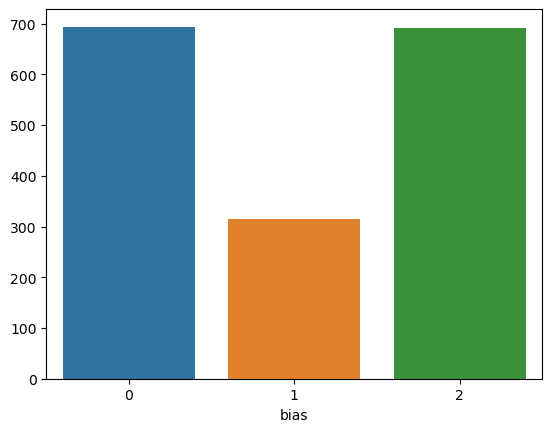

In [17]:
bias_vals = train_data['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show()

## Preprocessing All Dataset

### Cleaning and removing non necessary words

english _stop words


In [18]:
_stopwords = nltk.corpus.stopwords.words("english")

Cleaning dataset:


In [19]:
print(type(train_data["text_content"][0]))

<class 'str'>


In [22]:
def clean(text):  #Removing unecessary punctuation and all lower case.
    text = re.sub(r'\|\|\|', r' ', text) 
    text = text.replace('„','')
    text = text.replace('“','')
    text = text.replace('"','')
    text = text.replace('\'','')
    text = text.replace('-','')

    for i in range(330):
        text= text.replace(f"[{i}]","")

    text = text.lower()
    return text

def remove_stopwords(content): #Removing stopwords that are not needed for NLP
    for word in _stopwords:
        content = content.replace(' '+word+' ',' ')
    return content

#train_data
train_data['text_content'] = train_data['text_content'].apply(clean)
train_data['text_content'] = train_data['text_content'].apply(remove_stopwords)

#test_data
test_data['text_content'] = test_data['text_content'].apply(clean)
test_data['text_content'] = test_data['text_content'].apply(remove_stopwords)

### Creating balanced train set (if already balanced : no valid_train dataset)

In [26]:
np.random.seed=10
length = [len(train_data[train_data["bias"] == i]) for i in [0,1,2]] #Define if a class is underpresented
a=np.min(length)
a=200
# Select rows for each class and combine them
indices = []
indices_test=[]

for bias_class in [0,1,2]:
    indices.extend(train_data[train_data["bias"] == bias_class].index[:a])
    indices_test.extend(train_data[train_data["bias"] == bias_class].index[a:])
# Create the training dataset
train = train_data.loc[indices[:]]
train = train.iloc[np.random.permutation(len(train))]
print(train["bias"].value_counts())
test_train= train_data.loc[indices_test[:]]
test_train = test_train.iloc[np.random.permutation(len(test_train))]
print(test_train["bias"].value_counts())


bias
1    200
0    200
2    200
Name: count, dtype: int64
bias
0    491
2    491
1     18
Name: count, dtype: int64


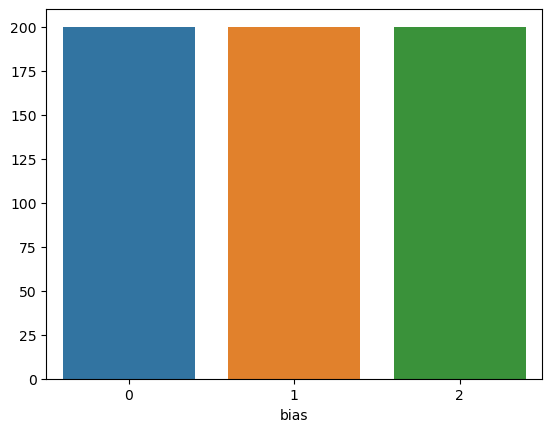

In [27]:
bias_vals = train['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show()

### Tokenize the text content of all dataset

In [28]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 3:
                continue
            tokens.append(word.lower())
    return tokens


#Train dataset
train_tagged = train.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text_content']), tags=  [r.bias]), axis=1)

valid_train_tagged = test_train.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text_content']), tags=  [r.bias]), axis=1)

#Pred dataset
test_data_tagged = test_data.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text_content']), tags=[]), axis=1)

## Vectorizing each document from the data
(May take some times: up to 15 mins, we use the Distributed bag of word D-BOW)

Elements in Doc2Vec :

vector_size (int): Dimensionality of the feature vectors. This is the size of the vectors that represent each document.

window (int): Maximum distance between the current and predicted word within a sentence. It influences the context window for word prediction.

min_count (int): Ignores all words with a total frequency lower than this.

workers (int): Number of CPU cores to use when training the model. Parallelization speeds up training.

epochs (int): Number of iterations (epochs) over the corpus during training. This parameter controls how many times the model iterates over the entire dataset.

dm (int, {1, 0}): Defines the training algorithm. If dm=1, the PV-DM (Distributed Memory) model is used. If dm=0, the PV-DBOW (Distributed Bag of Words) model is used.

dbow_words (int, {1, 0}): If set to 1, trains word vectors as well as document vectors. This is only effective when using the PV-DBOW model.

dm_concat (int, {1, 0}): If set to 1, concatenates paragraph vectors rather than averaging them in the PV-DM model.

dm_tag_count (int): Expected constant number of document tags per document during training.

hs (int, {1, 0}): If set to 1, hierarchical softmax will be used for model training.

negative (int): If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drawn (usually between 5-20).

### Initialize model and training it on the train dataset

In [34]:
cores = multiprocessing.cpu_count()
model = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, sample=0, min_count=0, workers=cores, epochs=25) # dm=0 --> PV-DBOW

model.build_vocab(train_tagged.values)  #The model builds his vocabulary on the training set
model.train(utils.shuffle(train_tagged.values), #model train on a mixed trained values and 50 steps
    total_examples=len(train_tagged.values),epochs=model.epochs)  


### Using trained model to learn to return document vectors and labels

In [35]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    classes, features = zip(*[(doc.tags[0],
      model.infer_vector(doc_words=doc.words, epochs=model.epochs)) for doc in sents]) #steps=epochs increase steps for better precision but more running time
    return features, classes


train_x, train_y= vec_for_learning(model, train_tagged) #Train data
test_train_x, test_train_y= vec_for_learning(model, valid_train_tagged) #test train data

## Classification methods : We use Support Vector Machine for Classification (SVM-C)

In [36]:
#Helper function for calculating accuracy on the test set.
def acc(true, pred):
  acc = 0
  for x,y in zip(true,pred):
    if(x == y): acc += 1
  return acc/len(pred)

### Creating the classifier model and cross validation

In [37]:
svc = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],            # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'degree': [2, 3, 4],               # Degree of the polynomial kernel (if kernel is 'poly')
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient for 'rbf' and 'poly'
    'coef0': [0.0, 1.0],   
}

grid_search=GridSearchCV(svc, param_grid, cv=5, scoring="accuracy")

grid_search.fit(train_x, train_y)
best_param= grid_search.best_params_


svc =SVC(**best_param, probability=True)

svc.fit(train_x,train_y)

print("Accuracy of the model trained = %0.2f %%"%(acc(train_y,svc.predict(train_x))*100)) #Accuracy of model depending on the fitting
print("Accuracy of the model with test train data = %0.2f %%"%(acc(test_train_y,svc.predict(test_train_x))*100)) #Accuracy of the model on verifying data

Accuracy of the model trained = 99.83 %
Accuracy of the model with test train data = 63.20 %


In [38]:
best_param
#{'C': 0.1, 'coef0': 1.0, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

{'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

### Vectorizing the test data (using D-BOW model)

In [39]:
def vectorizing_project_data(model, tagged_docs):
    sents = tagged_docs.values
    features = [model.infer_vector(doc.words, epochs=model.epochs) for doc in sents]
    return features

test_x = vectorizing_project_data(model, test_data_tagged)

### Prediction of Classes on the Test Set

In [44]:
test_labels=svc.predict(test_x)

test_data["Bias"] = test_labels
test_data["Bias"].value_counts()

Bias
2    2050
0    1964
1     590
Name: count, dtype: int64

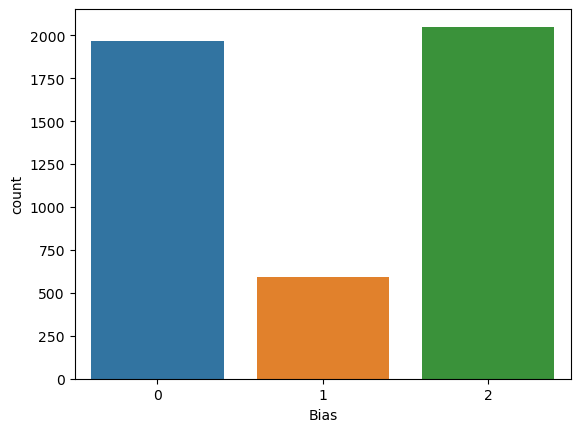

In [45]:
plt.figure()
sns.barplot(x=test_data["Bias"].value_counts().index, y=test_data["Bias"].value_counts())
plt.show()

In [46]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer


model2=BernoulliNB()
model2.fit(train_x, train_y)
print(acc(train_y,model2.predict(train_x)))
print(acc(test_train_y, model2.predict(test_train_x)))

0.9716666666666667
0.546


In [49]:
selected_columns=["title","Bias"]
test_data[selected_columns].to_csv("political_bias.csv")